In [954]:
import pandas as pd
import matplotlib.pyplot as plt

## Reading data 
df = pd.read_csv("hotel_booking.csv")


In [955]:
## Displaying all columns, and printing dataframe shape, useful for comparison after feature selection
pd.set_option('display.max_columns', None)
df.shape

(119390, 36)

In [956]:
## Dropping columns with lots of missing values, completion rate threshold set to 80%
def drop_sparse_cols(df):
    comprate = pd.DataFrame(df.count()/df.shape[0],columns=['comprate'])
    cleaned_df = df[list(comprate[comprate['comprate'] >= 0.8].index)]
    return cleaned_df

In [ ]:
## 1 column was dropped
cleaned_df = drop_sparse_cols(df)
cleaned_df.shape

(119390, 35)

In [958]:
## Drop useless columns : name, email, phone number, credit card
cleaned_df.drop(columns=['name','email','phone-number','credit_card'],inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_18476\1576572801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(columns=['name','email','phone-number','credit_card'],inplace=True)


In [959]:
cleaned_df.shape

(119390, 31)

In [960]:
def cols_missing_values(df):
    comprate = pd.DataFrame(df.count()/df.shape[0],columns=['comprate'])
    mv = list(comprate[comprate['comprate'] < 1].index)
    return mv, comprate[comprate['comprate'] < 1]

In [961]:
cols_mv, comprate_mv = cols_missing_values(cleaned_df)
#print(cols_mv)
comprate_mv

,comprate
children,0.999966
country,0.995913
agent,0.863138


In [962]:
import duckdb
import pandas
## We'll decide how to deal with each column accordingly
# Starting with agent. Is agent a predictive variable for is_labeled ? 
# A Null agent number means the booking was made outside of an agency, so we do not drop the missing rows.
agent_count = duckdb.sql("""SELECT agent, count(agent) as CNT
                        FROM cleaned_df
                        GROUP BY agent
                        ORDER BY CNT desc
                     """).df()
#cleaned_df[cleaned_df['is_canceled','agent']].corr

In [963]:
agent_count['percentage'] = agent_count['CNT']/cleaned_df.shape[0]
agent_count[agent_count['CNT'] >= 1000]

,agent,CNT,percentage
0,9.0,31961,0.267702
1,240.0,13922,0.116609
2,1.0,7191,0.060231
3,14.0,3640,0.030488
4,7.0,3539,0.029642
5,6.0,3290,0.027557
6,250.0,2870,0.024039
7,241.0,1721,0.014415
8,28.0,1666,0.013954
9,8.0,1514,0.012681


In [964]:
agent_transformed = duckdb.sql("""SELECT agent, 
                        CASE WHEN agent IS NULL THEN 'self-reservation'
                        ELSE CONCAT('A',CAST(CAST(agent AS INT) AS STRING))
                        END AS t_agent
                    FROM cleaned_df
                 """).df()
cleaned_df["agent"] = agent_transformed["t_agent"].values

C:\Users\PC\AppData\Local\Temp\ipykernel_18476\2444997697.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["agent"] = agent_transformed["t_agent"].values


In [965]:
cleaned_df[["agent","is_canceled"]]

to_plot = duckdb.sql("""SELECT agent, 
                            is_canceled,
                            COUNT(is_canceled) AS tot_count
                        FROM cleaned_df
                        GROUP BY agent, is_canceled
                        ORDER BY tot_count DESC
                    """).df()

In [966]:
to_plot[to_plot["tot_count"] >= 500]

,agent,is_canceled,tot_count
0,A9,0,18697
1,A9,1,13264
2,self-reservation,0,12310
3,A240,0,8438
4,A240,1,5484
5,A1,1,5280
6,self-reservation,1,4030
7,A7,0,3065
8,A14,0,2988
9,A250,0,2357


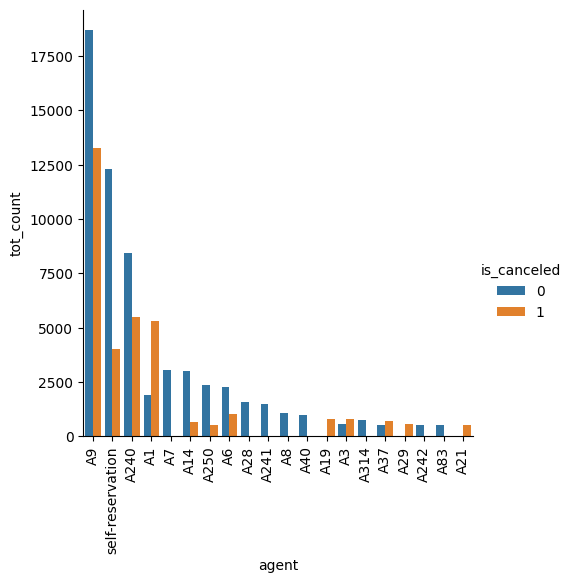

In [967]:
import seaborn as sns
## Interesting plot here : some agencies have more cancel requests than other
## Business idea, but not ML related, find out cancelling seasonality for each "cancel-intensive" agencies 

drawing = sns.catplot(
    data = to_plot[to_plot["tot_count"] >= 500], kind='bar',
    x = 'agent', y='tot_count',hue='is_canceled'
)

drawing.set_xticklabels(rotation=90)

In [ ]:
## After further analysis, I will drop this agent column, because it has multiple categories, therefore weak predictive power (is it though ? hmm)
cleaned_df.drop(columns=["agent"],inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_18476\615649269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(columns=["agent"],inplace=True)


In [969]:
cleaned_df.shape

(119390, 30)

In [970]:
# For the other missing values (has_children, country). We will simply remove the rows
cleaned_df.dropna(inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_18476\1197043764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.dropna(inplace=True)


In [971]:
## dataframe shape comparison after a 1st wave of cleaning
cleaned_df.shape

(118898, 30)

In [972]:
cleaned_df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

In [973]:
## A heuristic, intuition-based decision to drop irrelevant columns for our prediction use-case
cleaned_df.drop(columns=["reservation_status", "reservation_status_date", "required_car_parking_spaces", "days_in_waiting_list","reserved_room_type","assigned_room_type","customer_type"],inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_18476\1351466909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(columns=["reservation_status", "reservation_status_date", "required_car_parking_spaces", "days_in_waiting_list","reserved_room_type","assigned_room_type","customer_type"],inplace=True)


In [ ]:

## 1st feature engineering wave
from numpy import sin, cos, pi, round, ceil
import calendar
def encoding_1(df):

    # Aggregating some columns, transforming some others
    df['total_days_stayed'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
    df['total_guests'] = df['adults'] + df['children'] + df['babies']
    df['has_baby'] = df['babies'].apply(lambda x:1 if x>0 else 0)
    df['has_children'] = df['children'].apply(lambda x:1 if x>0 else 0)
    df['meal'] = [0 if x in ['SC','Undefined'] else 1 if x == 'BB' else 2 if x == 'HB' else 3 for x in df["meal"]]
    
    # Binary-encoding of market-segment
    df['is_OnlineTA'] = df['market_segment'].apply(lambda x: 1 if x == 'Online TA' else 0)
    df['is_OfflineTATO'] = df['market_segment'].apply(lambda x: 1 if x == 'Offline TA/TO' else 0)
    df['is_Groups'] = df['market_segment'].apply(lambda x: 1 if x == 'Groups' else 0)  
    df['is_OtherMarketSegment'] = df['market_segment'].apply(lambda x: 1 if x not in ['Online TA','Groups','Offline TA/TO'] else 0)

    # Binary-encoding of deposit-type
    df["is_NoDeposit"] = df["deposit_type"].apply(lambda x: 1 if x == "No Deposit" else 0)
    df["is_Refundable"] = df["deposit_type"].apply(lambda x: 1 if x == "Refundable" else 0)
    df["is_NonRefund"] = df["deposit_type"].apply(lambda x: 1 if x == "Non Refund" else 0) 
    

    # Lead time transformed into 10-day bins
    df["lead_time"] = df["lead_time"].apply(lambda x: int(ceil(x/10)*10)+10)
    
    # Year hot encoded
    df['is_2015'] = df['arrival_date_year'].apply(lambda x:1 if x == 2015 else 0)
    df['is_2016'] = df['arrival_date_year'].apply(lambda x:1 if x == 2016 else 0)
    df['is_2017'] = df['arrival_date_year'].apply(lambda x:1 if x == 2017 else 0)

    # Processing datetime variables for cyclical encoding
    month_map = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9, 'October':10, 'November': 11, 'December':12}
    df['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: month_map[x])
    df['arrival_date_month_sin'] = round(sin((df['arrival_date_month']-1)*(2*pi/12)),2)
    df['arrival_date_month_cos'] = round(cos((df['arrival_date_month']-1)*(2*pi/12)),2)
    
    df['arrival_date_week_number_sin'] = round(sin((df['arrival_date_week_number']-1)*(2*pi/53)),2)
    df['arrival_date_week_number_cos'] = round(cos((df['arrival_date_week_number']-1)*(2*pi/53)),2)
    
    df['arrival_date_day_of_month_sin'] = round(sin((df['arrival_date_day_of_month']-1)*(2*pi/31)),2)
    df['arrival_date_day_of_month_cos'] = round(cos((df['arrival_date_day_of_month']-1)*(2*pi/31)),2)

    for_visualisation = df.copy()

    # Dropping the initial transformed columns
    df.drop(columns=["distribution_channel","deposit_type","market_segment","meal","country","arrival_date_month","arrival_date_week_number","arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","arrival_date_year","adults","children","babies"],inplace=True)

    return df, for_visualisation

cleaned_df_encoded, vis_cleaned_df = encoding_1(cleaned_df)
 
print(cleaned_df_encoded.shape)

C:\Users\PC\AppData\Local\Temp\ipykernel_18476\2063517940.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_days_stayed'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
C:\Users\PC\AppData\Local\Temp\ipykernel_18476\2063517940.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_guests'] = df['adults'] + df['children'] + df['babies']
C:\Users\PC\AppData\Local\Temp\ipykernel_18476\2063517940.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

(118898, 29)


C:\Users\PC\AppData\Local\Temp\ipykernel_18476\2063517940.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["distribution_channel","deposit_type","market_segment","meal","country","arrival_date_month","arrival_date_week_number","arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","arrival_date_year","adults","children","babies"],inplace=True)


In [975]:
print(cleaned_df_encoded.shape)
print(vis_cleaned_df.shape)


(118898, 29)
(118898, 43)


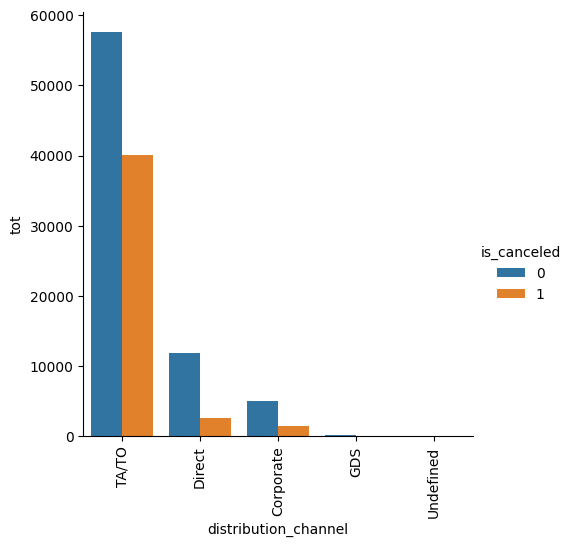

In [976]:
def visualize_against_target(variable,over1000=False):
    plot = duckdb.sql("""SELECT {}, is_canceled, count(*) as tot
                    FROM vis_cleaned_df
                    GROUP BY {}, is_canceled 
                        ORDER BY tot DESC
                        """.format(variable,variable)).df()
    if over1000:
            drawing = sns.catplot(
        data = plot[plot["tot"] >= 1000], kind='bar',
        x = variable, y='tot',hue='is_canceled'
    )
    else : 
        drawing = sns.catplot(
            data = plot, kind='bar',
            x = variable, y='tot',hue='is_canceled'
        )

    drawing.set_xticklabels(rotation=90)        
    


visualize_against_target("distribution_channel")

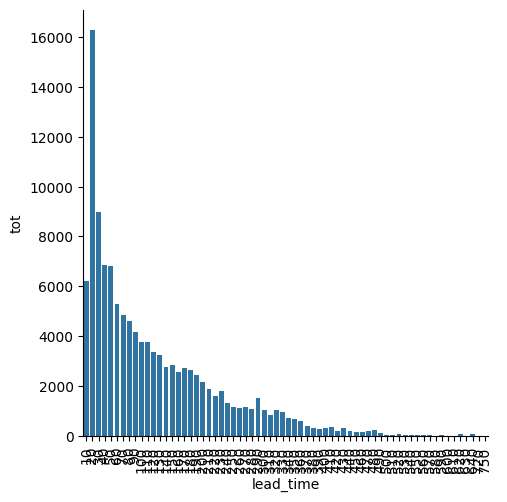

In [977]:
def visualize_distribution(variable,over1000=False):
  plot = duckdb.sql("""SELECT {}, count(*) AS tot
                    FROM vis_cleaned_df
                    GROUP BY {}
                    ORDER BY tot DESC
                  """.format(variable,variable)).df()
  
  if over1000 :
    drawing = sns.catplot(
      data = plot[plot["tot"]>= 1000], kind='bar',
      x = variable, y='tot'
  )

  else : 
    drawing = sns.catplot(
        data = plot, kind='bar',
        x = variable, y='tot'
    )

  drawing.set_xticklabels(rotation=90)

visualize_distribution("lead_time")

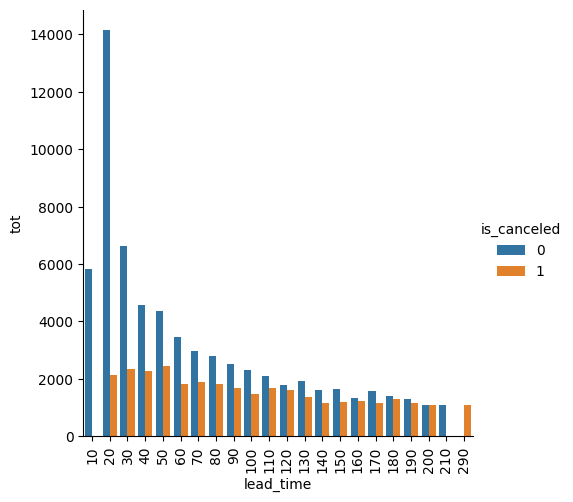

In [978]:
visualize_against_target("lead_time",True)

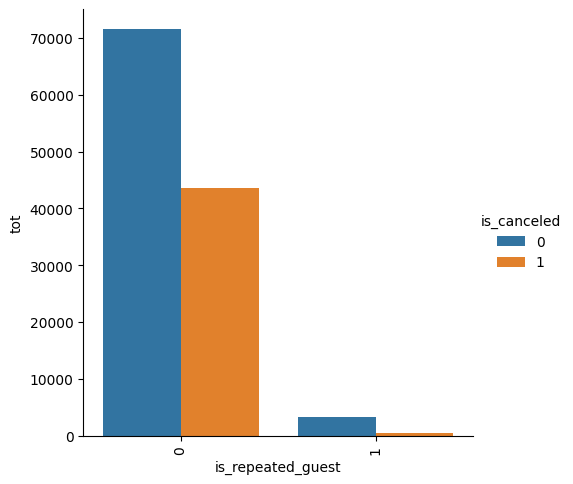

In [979]:
visualize_against_target("is_repeated_guest")

In [980]:
# Dataframe shape comparison
print(cleaned_df_encoded.shape)

(118898, 29)


In [981]:
cleaned_df_encoded.head()

,hotel,is_canceled,lead_time,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,adr,total_of_special_requests,total_days_stayed,total_guests,has_baby,has_children,is_OnlineTA,is_OfflineTATO,is_Groups,is_OtherMarketSegment,is_NoDeposit,is_Refundable,is_NonRefund,is_2015,is_2016,is_2017,arrival_date_month_sin,arrival_date_month_cos,arrival_date_week_number_sin,arrival_date_week_number_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos
0,Resort Hotel,0,360,0,0,0,3,0.0,0,0,2.0,0,0,0,0,0,1,1,0,0,1,0,0,0.0,-1.0,0.06,-1.0,0.0,1.0
1,Resort Hotel,0,750,0,0,0,4,0.0,0,0,2.0,0,0,0,0,0,1,1,0,0,1,0,0,0.0,-1.0,0.06,-1.0,0.0,1.0
2,Resort Hotel,0,20,0,0,0,0,75.0,0,1,1.0,0,0,0,0,0,1,1,0,0,1,0,0,0.0,-1.0,0.06,-1.0,0.0,1.0
3,Resort Hotel,0,30,0,0,0,0,75.0,0,1,1.0,0,0,0,0,0,1,1,0,0,1,0,0,0.0,-1.0,0.06,-1.0,0.0,1.0
4,Resort Hotel,0,30,0,0,0,0,98.0,1,2,2.0,0,0,1,0,0,0,1,0,0,1,0,0,0.0,-1.0,0.06,-1.0,0.0,1.0


In [982]:
# EDA : Exploratory data analysis for each variable
cleaned_df_encoded.columns.tolist()

['hotel',
 'is_canceled',
 'lead_time',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'adr',
 'total_of_special_requests',
 'total_days_stayed',
 'total_guests',
 'has_baby',
 'has_children',
 'is_OnlineTA',
 'is_OfflineTATO',
 'is_Groups',
 'is_OtherMarketSegment',
 'is_NoDeposit',
 'is_Refundable',
 'is_NonRefund',
 'is_2015',
 'is_2016',
 'is_2017',
 'arrival_date_month_sin',
 'arrival_date_month_cos',
 'arrival_date_week_number_sin',
 'arrival_date_week_number_cos',
 'arrival_date_day_of_month_sin',
 'arrival_date_day_of_month_cos']

In [ ]:
X = cleaned_df_encoded.drop(columns=["hotel","is_canceled"])
y = cleaned_df_encoded["is_canceled"]

print("Explaining variable shape : ",X.shape)
print("Target variable shape :", y.shape)

Explaining variable shape :  (118898, 27)
Target variable shape : (118898,)


In [1003]:
## And now we go to feature selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
from numpy import round

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)


dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

def fit_predict(clf):
    clf = clf.fit(X_train,y_train)
    return clf.predict(X_test)

def eval(clf):
    y_pred = fit_predict(clf)
    p, r, f1, supp = precision_recall_fscore_support(y_test,y_pred)
    cm = confusion_matrix(y_test, y_pred,labels=[0,1])
    return round(p,2), round(r,2), round(f1,2), supp, cm

def plot_eval(clf):
    p, r, f1, supp, cm = eval(clf)
    print(f"Evaluating {clf}")
    print(f"Precision : {p}\n")
    print(f"Recall : {r}\n")
    print(f"F1-score : {f1}\n")
    print(f"Support : {supp}\n")
    print("Plotting confusion matrix heatmap...")
    sns.heatmap(cm, annot=True, fmt= 'd')


Evaluating DecisionTreeClassifier(random_state=42)
Precision : [0.85 0.74]

Recall : [0.84 0.75]

F1-score : [0.85 0.75]

Support : [14949  8831]

Plotting confusion matrix heatmap...


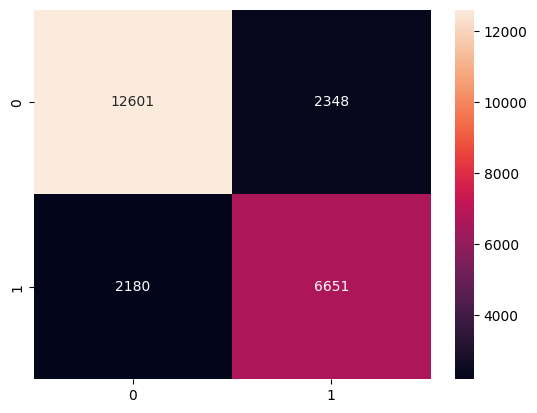

In [1004]:
plot_eval(dt)

Evaluating RandomForestClassifier(random_state=42)
Precision : [0.86 0.85]

Recall : [0.92 0.74]

F1-score : [0.89 0.79]

Support : [14949  8831]

Plotting confusion matrix heatmap...


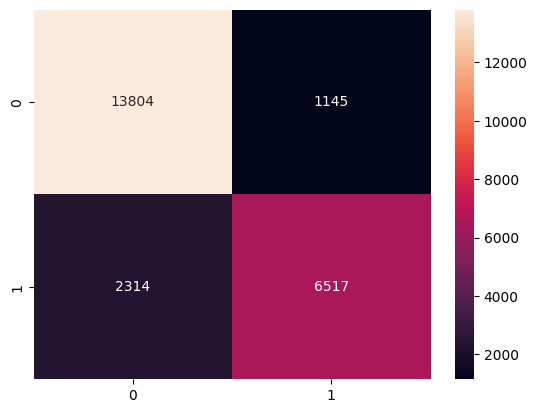

In [1005]:
plot_eval(rf)

In [1024]:
def get_feature_importance(clf):
    fi = {}
    for i in range(X_train.shape[1]):
        fi[X_train.columns.tolist()[i]] = round(clf.feature_importances_[i],3)
    return sorted(fi.items(), key=lambda x:x[1])
        #rf.feature_importances_

In [1025]:
get_feature_importance(dt)

[('is_NoDeposit', 0.0),
 ('is_Refundable', 0.0),
 ('is_repeated_guest', 0.001),
 ('has_baby', 0.001),
 ('is_Groups', 0.002),
 ('is_OtherMarketSegment', 0.002),
 ('is_OfflineTATO', 0.003),
 ('has_children', 0.005),
 ('is_2015', 0.006),
 ('is_2016', 0.006),
 ('previous_bookings_not_canceled', 0.008),
 ('is_2017', 0.009),
 ('arrival_date_month_cos', 0.01),
 ('arrival_date_month_sin', 0.011),
 ('booking_changes', 0.017),
 ('total_guests', 0.02),
 ('previous_cancellations', 0.033),
 ('arrival_date_week_number_cos', 0.034),
 ('arrival_date_week_number_sin', 0.037),
 ('is_OnlineTA', 0.04),
 ('total_of_special_requests', 0.057),
 ('arrival_date_day_of_month_cos', 0.059),
 ('total_days_stayed', 0.067),
 ('arrival_date_day_of_month_sin', 0.068),
 ('lead_time', 0.119),
 ('adr', 0.147),
 ('is_NonRefund', 0.238)]

In [1026]:
get_feature_importance(rf)

[('has_baby', 0.001),
 ('is_Refundable', 0.001),
 ('is_repeated_guest', 0.002),
 ('previous_bookings_not_canceled', 0.004),
 ('has_children', 0.006),
 ('is_2017', 0.007),
 ('is_2015', 0.008),
 ('is_2016', 0.008),
 ('is_OfflineTATO', 0.01),
 ('is_Groups', 0.01),
 ('is_OtherMarketSegment', 0.011),
 ('arrival_date_month_sin', 0.017),
 ('arrival_date_month_cos', 0.017),
 ('booking_changes', 0.024),
 ('total_guests', 0.024),
 ('is_OnlineTA', 0.027),
 ('arrival_date_week_number_cos', 0.036),
 ('arrival_date_week_number_sin', 0.037),
 ('previous_cancellations', 0.04),
 ('arrival_date_day_of_month_cos', 0.059),
 ('total_of_special_requests', 0.066),
 ('arrival_date_day_of_month_sin', 0.066),
 ('total_days_stayed', 0.068),
 ('is_NoDeposit', 0.083),
 ('is_NonRefund', 0.098),
 ('adr', 0.134),
 ('lead_time', 0.136)]

In [ ]:
## Not much insight lol